In [90]:
# PARTIE LECTURE CSV ET MISE EN PLACE INFOS DANS UN CSV PROPRE

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pandas as pd
import numpy as np
import os

os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

# ======== PARTIE LECTURE DU CSV ===========
df = pd.read_csv("agenda.csv",sep = '\t')

# Le fichier CSV doit être de la forme :
"""FORMAT AGENDA :
    JOUR         HEURE         ACTIVITE
    ...          ...           ...
    ...          ...           ...
"""


# ======== PARTIE CREATION DES VARIABLES =========
# Variables créées à partir du csv
Actis = df['ACTIVITE'].unique() #Actis = ['Maison','Travail','Repas','Sport','Ecole','Golf','Plancha','Promenade','Rien']
c = gum.LabelizedVariable("calendar","User Calendar",Actis)

#Jours = df['JOUR'].unique() #['Lundi','Mardi','Mercredi','Jeudi','Vendredi','Samedi','Dimanche']
#Heures = df['HEURE'].unique().astype(str) #['7','8','9','10','11','12','13','14','15','16','17','18','19','20']

# Variables fixes
d = gum.LabelizedVariable("day","Day of the week",['Lundi','Mardi','Mercredi','Jeudi','Vendredi','Samedi','Dimanche'])
h = gum.LabelizedVariable("hour","Hour of the day",['7','8','9','10','11','12','13','14','15','16','17','18','19','20'])

# Informations reçues par le broker
pA = gum.LabelizedVariable("phoneActivity","Phone's mvt",['no activity','low activity','high activity'])
pL = gum.LabelizedVariable("phoneLoc","Phone's localisation",['maison','travail','cantine','sport','ecole','golf','maisonAmis','inconnue'])
wA = gum.LabelizedVariable("watchActivity","Watch's mvt",['no activity','low activity','high activity'])
wL = gum.LabelizedVariable("watchLoc","Watch's localisation",['maison','travail','cantine','sport','ecole','golf','maisonAmis','inconnue'])

cR = gum.LabelizedVariable("contextReliability","Reliability of the context",['reliable','doubts','notReliable'])

# ========= PARTIE CREATION BN ===========
bn = gum.BayesNet('ContextInfoReliability')
day = bn.add(d)
hour = bn.add(h)
calendar = bn.add(c)
pActi = bn.add(pA)
pLoc = bn.add(pL)
wActi = bn.add(wA)
wLoc = bn.add(wL)
contextReliability = bn.add(cR)

# ======= CREATION DES LIENS DU BN ===========
bn.addArc(hour,calendar)
bn.addArc(day,calendar)
bn.addArc(calendar,contextReliability)
bn.addArc(pActi,contextReliability)
bn.addArc(wActi,contextReliability)
bn.addArc(pLoc,contextReliability)
bn.addArc(wLoc,contextReliability)


# ======= REMPLISSAGE DES PROBAS ==========
# Probas toujours identiques car répartitions égales qui ne changent jamais
bn.cpt(day)[:]=[0.1429,0.1428,0.1429,0.1428,0.1429,0.1428,0.1429]
bn.cpt(hour)[:]=[0.07,0.07,0.07,0.07,0.07,0.08,0.08,0.07,0.07,0.07,0.07,0.07,0.07,0.07]

# Remplissage des probas du calendrier
for i in range(0,len(df)):
    if df.iloc[i,2] == Actis[len(Actis)-1]:
        bn.cpt(calendar)[df.iloc[i,0],str(df.iloc[i,1]),:] = [0.14,0.01,0.14,0.14,0.01,0.14,0.14,0.14,0.14]
    else :
        for k in range(0,len(Actis)-1):
            tab = np.zeros(len(Actis)) + 0.00625
            if df.iloc[i,2] == Actis[k]:
                tab[k] = 0.95;
                bn.cpt(calendar)[df.iloc[i,0],str(df.iloc[i,1]),:] = tab

# Remplissage des probas générales
df['count'] = 1
df2 = df.groupby(['ACTIVITE'],sort=False).count()['count']
tot = df2.sum()
tab  = np.zeros(len(pL.labels()))
for i in range(0,len(df2)):
    if i == len(df2)-1:
        tab[i-1] = tab[i-1] + df2.iloc[i]/tot
    else :
        tab[i] = df2.iloc[i]/tot

bn.cpt(pLoc)[:] = tab
bn.cpt(wLoc)[:] = tab
bn.cpt(pActi)[:] = [0.4,0.4,0.2]
bn.cpt(wActi)[:] = [0.4,0.4,0.2]

# Remplissage des probas de contextReliability


for i in range(0,len(c.labels())):
    for k in range(0,len(pA.labels())):
        for j in range (0,len(pL.labels())):
            for g in range(0,len(wA.labels())):
                for h in range (0,len(wL.labels())):
                    bn.cpt(contextReliability)[wL.label(h),pL.label(j),wA.label(g),pA.label(k),c.label(i),:]=[0.02,0.1,0.88]

for i in range(0,len(c.labels())):
    for k in range(0,len(pA.labels())):
        for j in range (0,len(pL.labels())):
            if j == i or (i == len(c.labels())-1 and j == len(pL.labels())-1):
                bn.cpt(contextReliability)[wL.label(j),pL.label(j),wA.label(k),pA.label(k),c.label(i),:]=[0.96,0.02,0.02]
            else :
                bn.cpt(contextReliability)[wL.label(j),pL.label(j),wA.label(k),pA.label(k),c.label(i)]=[0.1,0.8,0.1]



In [81]:
bn.cpt(contextReliability)[:][:][:][:][:]

array([[[[[[0.96, 0.02, 0.02],
           [0.1 , 0.8 , 0.1 ],
           [0.1 , 0.8 , 0.1 ],
           ...,
           [0.1 , 0.8 , 0.1 ],
           [0.1 , 0.8 , 0.1 ],
           [0.1 , 0.8 , 0.1 ]],

          [[0.  , 0.  , 0.  ],
           [0.  , 0.  , 0.  ],
           [0.  , 0.  , 0.  ],
           ...,
           [0.  , 0.  , 0.  ],
           [0.  , 0.  , 0.  ],
           [0.  , 0.  , 0.  ]],

          [[0.  , 0.  , 0.  ],
           [0.  , 0.  , 0.  ],
           [0.  , 0.  , 0.  ],
           ...,
           [0.  , 0.  , 0.  ],
           [0.  , 0.  , 0.  ],
           [0.  , 0.  , 0.  ]]],


         [[[0.  , 0.  , 0.  ],
           [0.  , 0.  , 0.  ],
           [0.  , 0.  , 0.  ],
           ...,
           [0.  , 0.  , 0.  ],
           [0.  , 0.  , 0.  ],
           [0.  , 0.  , 0.  ]],

          [[0.96, 0.02, 0.02],
           [0.1 , 0.8 , 0.1 ],
           [0.1 , 0.8 , 0.1 ],
           ...,
           [0.1 , 0.8 , 0.1 ],
           [0.1 , 0.8 , 0.1 ],
           

In [83]:
bn.cpt(contextReliability)

(gum::Potential<double>@0x29f98d9f140) 
                                  ||  contextReliability         |
calend|phoneA|watchA|phoneL|watchL||reliable |notReliab|doubts   |
------|------|------|------|------||---------|---------|---------|
Maison|no act|no act|maison|maison|| 0.9600  | 0.0200  | 0.0200  |
Travai|no act|no act|maison|maison|| 0.1000  | 0.8000  | 0.1000  |
Repas |no act|no act|maison|maison|| 0.1000  | 0.8000  | 0.1000  |
Sport |no act|no act|maison|maison|| 0.1000  | 0.8000  | 0.1000  |
Ecole |no act|no act|maison|maison|| 0.1000  | 0.8000  | 0.1000  |
Golf  |no act|no act|maison|maison|| 0.1000  | 0.8000  | 0.1000  |
[...5172 more line(s) ...]
Sport |high a|high a|inconn|inconn|| 0.1000  | 0.8000  | 0.1000  |
Ecole |high a|high a|inconn|inconn|| 0.1000  | 0.8000  | 0.1000  |
Golf  |high a|high a|inconn|inconn|| 0.1000  | 0.8000  | 0.1000  |
Planch|high a|high a|inconn|inconn|| 0.1000  | 0.8000  | 0.1000  |
Promen|high a|high a|inconn|inconn|| 0.9600  | 0.0200  | 0.0200  |
Rien  |high a|high a|inconn|inconn|| 0.9600  | 0.0200  | 0.0200  |

In [48]:
vc=gum.LabelizedVariable("c","c",['X','Y','Z'])
print(vc)

c<X,Y,Z>


In [73]:
pLoc = gum.LabelizedVariable("phoneLoc","Phone's localisation",['maison','travail','cantine','sport','ecole','golf','maisonAmis','inconnue'])
print(pLoc)
len( pLoc.labels())

phoneLoc<maison,travail,cantine,sport,ecole,golf,maisonAmis,inconnue>


8

In [4]:
bn

(gum::BayesNet<double>@0x2e77e7699a0) BN{nodes: 8, arcs: 7, domainSize: 10^6.18301, dim: 16477}

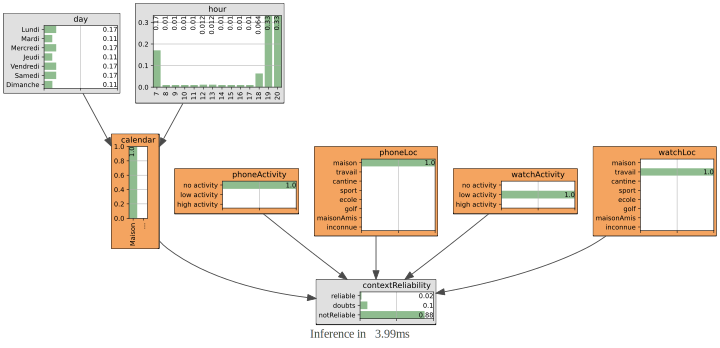

In [91]:
gnb.showInference(bn,size="10",evs={'calendar':'Maison','phoneLoc':'maison','watchLoc':'travail','phoneActivity':'no activity','watchActivity':'low activity'})

In [14]:
0.005*9 + 0.955

1.0